In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


### Automatic Feature Selection

Often we collect many features that might be related to a supervised prediction task, but we don't know which of them are actually predictive. We can use automatic feature selection to select a subset of the original features. 

The best feature selection strategy would be to try out each possible subset of the features, and evaluate generalization performance using this subset. However, there are exponentially many subsets of features, so this exhaustive search is generally infeasible. 

### Univariate Statistics

The simplest method to select features is using univariate statistics, this kind of test is also known as analysis of variance (ANOVA).

In [2]:
from sklearn.datasets import load_breast_cancer, load_digits
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()

# get deterministic random numbers
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer.data), 50))
# add noise features to the data
# the first 30 features are from the data set, the next 50 are noise
X_w_noise = np.hstack([cancer.data, noise])

X_train, X_test, y_train, y_test = train_test_split(X_w_noise, cancer.target,
                                                   random_state=0, test_size=.5)

In [3]:
from sklearn.feature_selection import SelectPercentile

# use f_classif (the default) and SelectPercentile to select 50% of features:
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)
# transform training set:
X_train_selected = select.transform(X_train)

print X_train.shape
print X_train_selected.shape

(284L, 80L)
(284L, 40L)


In [4]:
from sklearn.feature_selection import f_classif, f_regression, chi2
F, p = f_classif(X_train, y_train)

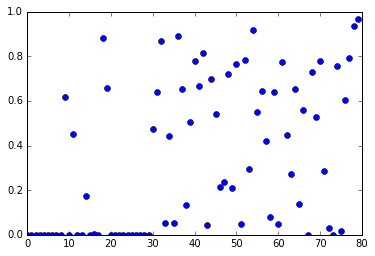

In [5]:
plt.figure()
plt.plot(p, 'o')

clearly most of the first 30 features have small p-values.

[ True  True  True  True  True  True  True  True  True False  True False
  True  True  True  True  True  True False False  True  True  True  True
  True  True  True  True  True  True False False False  True False  True
 False False  True False False False False  True False False  True False
 False  True False  True False False False False False False  True False
  True False False False False  True False  True False False False False
  True  True False  True False False False False]


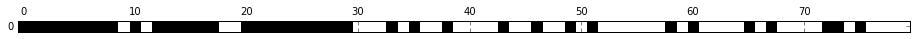

In [6]:
mask = select.get_support()
print(mask)
# visualize the mask black is true white is false
plt.matshow(mask.reshape(1,-1), cmap='gray_r')

Nearly all of the original 30 features were recovered. We can also analyze the ultilty of feature selection by training a supervised model on the data.

In [7]:
from sklearn.linear_model import LogisticRegression

# transform test data:
X_test_selected = select.transform(X_test)

lr = LogisticRegression()
lr.fit(X_train, y_train)
print "Score with all features: %f" % lr.score(X_test, y_test)
lr.fit(X_train_selected, y_train)
print "Score with only selected features: %f" % lr.score(X_test_selected, y_test)

Score with all features: 0.929825
Score with only selected features: 0.940351


### Model-based Feature Selection

A more sophisticated method for feature selection is using a supervised machine learning model and selecting features based on how important they were deemed by the model. This requies the model to rank the features by importance. This can be done in all tree-based models and linear models. 

In [8]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
select = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold='median')

In [9]:
select.fit(X_train, y_train)
X_train_rf = select.transform(X_train)
print(X_train.shape)
print(X_train_rf.shape)

(284L, 80L)
(284L, 40L)


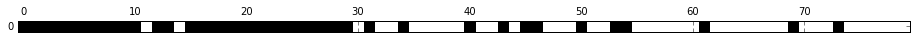

In [10]:
mask = select.get_support()
# visualize the mask. Black is True, white is false
plt.matshow(mask.reshape(1, -1), cmap='gray_r')

In [11]:
X_test_rf = select.transform(X_test)
LogisticRegression().fit(X_train_rf, y_train).score(X_test_rf, y_test)

0.9508771929824561

This method builds a single model and uses the feature importances from this model. We can do a more elaborate search by training multiple models on subsets of the data.

### Recursive Feature Elimination

Recursive feature elimination builds a model on the full set of features, and selects a subset of features that are deemed most important by the model. However, only a single feature is dropped from the dataset, and a new model is built with the remaining features. The process of dropping features and model building is repeated until there are only a pre-specified number of features left.

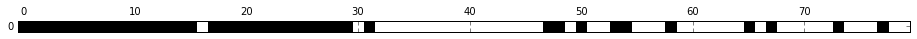

In [12]:
from sklearn.feature_selection import RFE
select = RFE(RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=40)

select.fit(X_train, y_train)
# visualize selected features
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')

In [14]:
X_train_rfe = select.transform(X_train)
X_test_rfe = select.transform(X_test)

LogisticRegression().fit(X_train_rfe, y_train).score(X_test_rfe, y_test)

0.9508771929824561

In [15]:
select.score(X_test, y_test)

0.9508771929824561